Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5, Average Training Loss: 0.0914, Average Training Accuracy: 0.9794
Epoch 2/5, Average Training Loss: 0.1146, Average Training Accuracy: 0.9950
Epoch 3/5, Average Training Loss: 0.1252, Average Training Accuracy: 0.9974
Epoch 4/5, Average Training Loss: 0.1294, Average Training Accuracy: 0.9993
Epoch 5/5, Average Training Loss: 0.1325, Average Training Accuracy: 0.9993
Accuracy: 0.9871
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1206
           1       0.93      0.97      0.95       187

    accuracy                           0.99      1393
   macro avg       0.96      0.98      0.97      1393
weighted avg       0.99      0.99      0.99      1393

[[1193   13]
 [   5  182]]


<ipython-input-3-434a5c2dcc5e>:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report_df.index, y=report_df['precision'], palette="viridis")


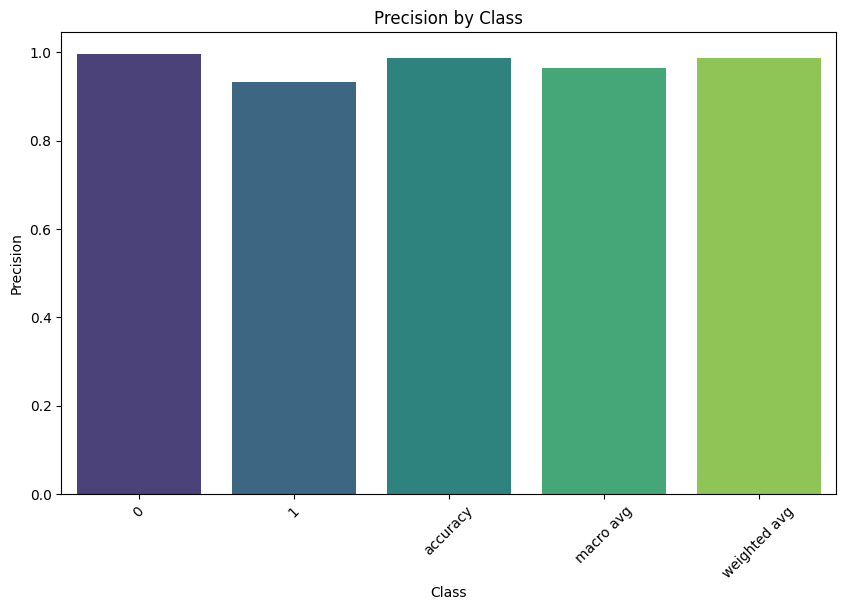

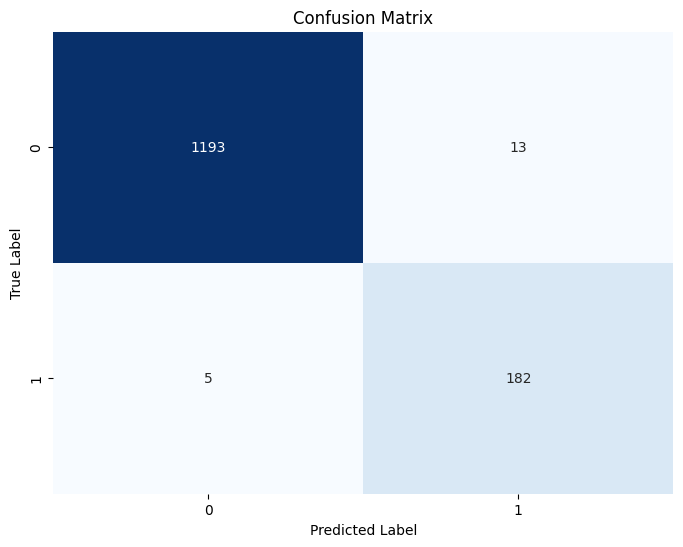

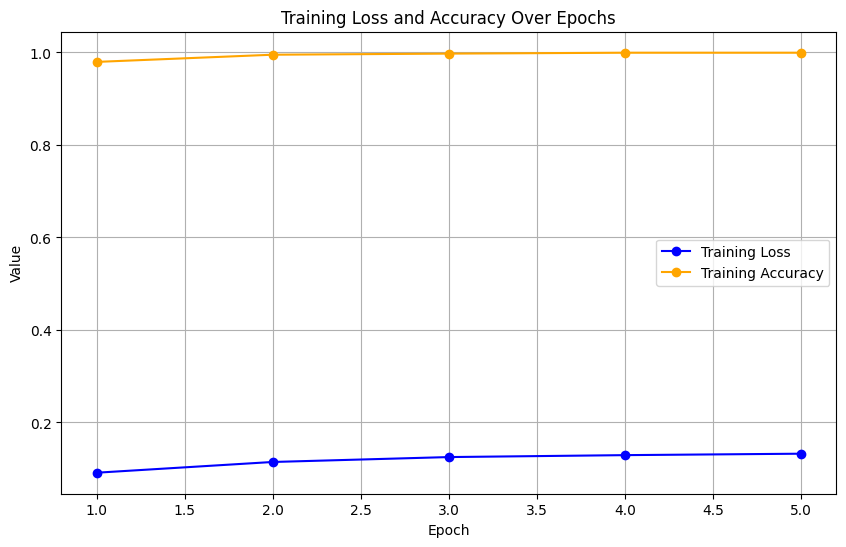

In [ ]:
# Install necessary libraries
!pip install transformers
!pip install --upgrade jax jaxlib

# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("spamdata_v2.csv")

# Split dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(df['text'], df['label'], stratify=df['label'])

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Tokenize inputs
max_length = 128  # Limit sequence length
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=max_length)

# Create TensorDatasets
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                              torch.tensor(train_labels.tolist()))

test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                             torch.tensor(test_encodings['attention_mask']),
                             torch.tensor(test_labels.tolist()))

# Define DataLoader with reduced batch size
batch_size = 16  # Reduce batch size
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop with gradient accumulation
accumulation_steps = 2  # Accumulate gradients over 2 steps
model.train()
total_loss = 0
train_losses = []  # List to store training losses over epochs
train_accuracies = []  # List to store training accuracies over epochs
for epoch in range(epochs):
    correct_predictions = 0
    total_predictions = 0
    for i, batch in enumerate(train_dataloader):
        if i % accumulation_steps == 0:
            optimizer.zero_grad()
        batch = tuple(t.to(device) for t in batch)
        inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        if (i + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()  # Update scheduler

        # Calculate accuracy
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(predictions == batch[2]).item()
        total_predictions += len(batch[2])

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    avg_train_accuracy = correct_predictions / total_predictions

    # Append training loss and accuracy for the epoch
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss:.4f}, Average Training Accuracy: {avg_train_accuracy:.4f}")

# Evaluation
model.eval()
predictions, true_labels = [], []
for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predictions.extend(torch.argmax(logits, dim=1).tolist())
    true_labels.extend(batch[2].tolist())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.4f}")

# Classification report and confusion matrix
print(classification_report(true_labels, predictions))
print(confusion_matrix(true_labels, predictions))

# Classification report bar plot
report = classification_report(true_labels, predictions, output_dict=True)
report_df = pd.DataFrame(report).transpose()
plt.figure(figsize=(10, 6))
sns.barplot(x=report_df.index, y=report_df['precision'], palette="viridis")
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Precision by Class')
plt.xticks(rotation=45)
plt.show()

# Confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot line graph of training loss and accuracy over epochs
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o', color='blue')

# Plot training accuracy
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy', marker='o', color='orange')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss and Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()
